<a href="https://colab.research.google.com/github/LiamSwick/Actuator-Scripts/blob/main/MLR_on_Actuator_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

# Load the Data

This data has been partially process in another notebook

In [ ]:
load = pd.read_csv('Clean Actuator Data.csv')

force_dummies = pd.get_dummies(load["Force [N]"], drop_first=True, prefix='Force')

df = pd.concat([load.iloc[:, :4], force_dummies], axis=1)
df = df.astype(float)
df.head()

,Current actual value [mA],Torque actual value [mNm],Velocity actual value [rpm],Velocity demand value [rpm],Force_2000,Force_3000
0,-956.516,-11.0,2.33,676.0,0.0,1.0
1,5630.401,270.0,137.39,1000.0,0.0,1.0
2,9173.858,444.0,66.78,1000.0,0.0,1.0
3,11282.541,519.0,237.88,1000.0,0.0,1.0
4,11760.799,519.0,463.48,1000.0,0.0,1.0


# Separate Data of Simulated Lift from Simulated Drop

In [178]:
up_mask = df['Velocity actual value [rpm]'] > 0
up_df = df[up_mask]
up_df.head()

,Current actual value [mA],Torque actual value [mNm],Velocity actual value [rpm],Velocity demand value [rpm],Force_2000,Force_3000
0,-956.516,-11.0,2.33,676.0,0.0,1.0
1,5630.401,270.0,137.39,1000.0,0.0,1.0
2,9173.858,444.0,66.78,1000.0,0.0,1.0
3,11282.541,519.0,237.88,1000.0,0.0,1.0
4,11760.799,519.0,463.48,1000.0,0.0,1.0


# Plot Heat Maps for Correlation Matrix

EDA step to investigate potential relationships

<Axes: >

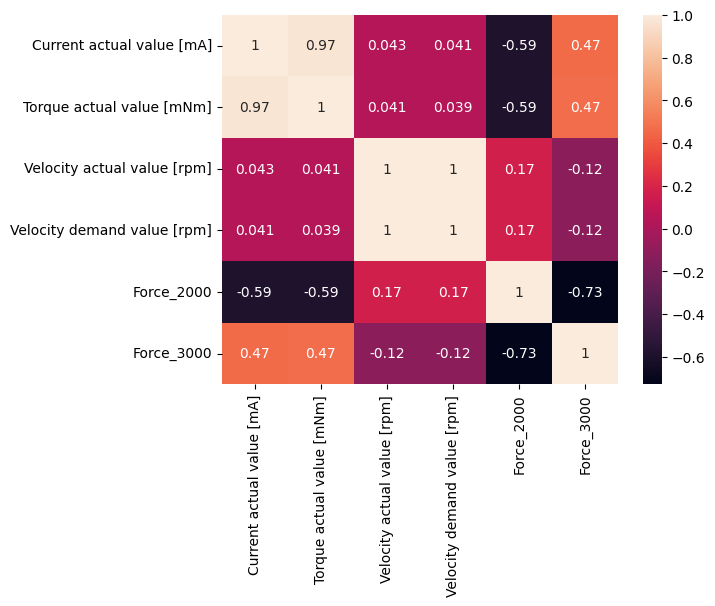

In [179]:
sns.heatmap(up_df.corr(), annot=True)

# Split Data into Train and Test Sets

We split the data in case we want to evaluate the model's predictive power later

In [196]:
x_cols = ['Velocity actual value [rpm]', 'Current actual value [mA]', 'Force_2000', 'Force_3000']
x = up_df[x_cols]
y = up_df['Torque actual value [mNm]']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the Regression Model to the Training Data

In [206]:
df_train_for_formula = x_train.copy()
df_train_for_formula['Torque actual value [mNm]'] = y_train

formula_str ="Q('Torque actual value [mNm]') ~ Q('Velocity actual value [rpm]') * (Force_2000 + Force_3000)"

mlr = sm.formula.ols(formula=formula_str, data=df_train_for_formula)
results = mlr.fit()

# View Results Chart for the Regression

In [207]:
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Q('Torque actual value [mNm]')   R-squared:                       0.461
Model:                                        OLS   Adj. R-squared:                  0.461
Method:                             Least Squares   F-statistic:                     4575.
Date:                            Sat, 03 Jan 2026   Prob (F-statistic):               0.00
Time:                                    21:42:42   Log-Likelihood:            -1.4980e+05
No. Observations:                           26753   AIC:                         2.996e+05
Df Residuals:                               26747   BIC:                         2.997e+05
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
                                                  coef    std err          t      P>|t|   

# Interpreting the Results

From the first portion of the table, we can say from the F-Test that at least one of the predictors is statistically significant (non-zero). However, we can also note from the $R^2$ value that the model does not fit the data very well. Depending on the intention of the model, we would ideally like to see $R^2 > 0.75$ if it is going to be used for prediction. This could mean that the data we have is either very noisy or we have omitted a variable along the way.

Moving on, we can see from the simultaneous T-tests, that our predictors are indeed deemed to be statistically significant, so we will not remove any predictors from the model. There will be an ANOVA to drive this point home in the next cell.

# Interpreting the model coefficients

All else held equal, for every +1 RPM increment, the torque value will increase by 0.0384 mNm. Since the force predictors were treated as categorical variables, the two categories "force_2000" and "force_3000" are being compared to the baseline "force_1000" while velocity is held constant at 0. From this, we can say that the effect on torque compared the 1000N of force is 135 mNm less for 2000N and 104 mNm more for 3000N.

# Evaluation of Regression Assumptions

According to the Durbin-Watson stat, we are not violating the assumtion of no autoregression. However, from the Jarque-Bera test there are some conserns about normality. Likewise, the high condition number should raise eyebrows about multicolinearity. So, we will investigate these next with some diagnostic plots.

In [208]:
from statsmodels.stats.anova import anova_lm
anova_table = anova_lm(results)
print(anova_table)

                                                  df        sum_sq  \
Q('Velocity actual value [rpm]')                 1.0  3.115968e+05   
Force_2000                                       1.0  7.851388e+07   
Force_3000                                       1.0  5.502542e+05   
Q('Velocity actual value [rpm]'):Force_2000      1.0  1.206912e+07   
Q('Velocity actual value [rpm]'):Force_3000      1.0  6.362409e+06   
Residual                                     26747.0  1.143648e+08   

                                                  mean_sq             F  \
Q('Velocity actual value [rpm]')             3.115968e+05     72.874514   
Force_2000                                   7.851388e+07  18362.387749   
Force_3000                                   5.502542e+05    128.690392   
Q('Velocity actual value [rpm]'):Force_2000  1.206912e+07   2822.658858   
Q('Velocity actual value [rpm]'):Force_3000  6.362409e+06   1488.004815   
Residual                                     4.275799e+03  

# ANOVA

From the ANOVA table we can see that all of the predictors used are deemed to be statistically significant.

In [209]:
# 1. Select the features used in your model
X_vif = df_train_for_formula[['Velocity actual value [rpm]', 'Force_2000', 'Force_3000']]

# 2. Add a constant (intercept) as VIF requires it
X_vif = sm.add_constant(X_vif)

# 3. Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("VIF Scores:")
print(vif_data)

VIF Scores:
                       Feature        VIF
0                        const  10.738671
1  Velocity actual value [rpm]   1.028529
2                   Force_2000   2.176346
3                   Force_3000   2.146763


#Variance Inflation Factor (VIF)

Seeing that our VIF scores for each feature except the intercept term are nearly 2, we should conclude that there isn't an issue with multicollinearity between the features.

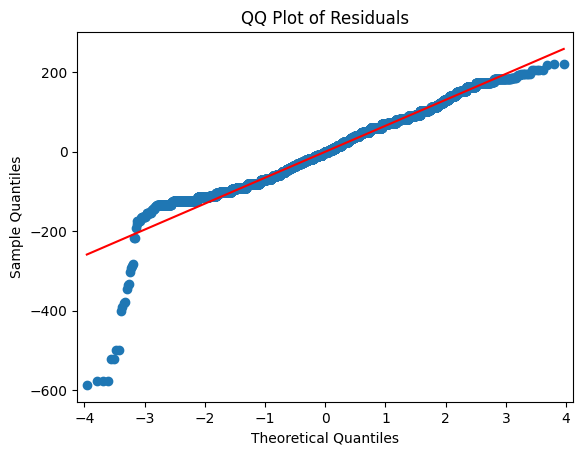

In [211]:
sm.qqplot(results.resid, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

# Quantile-Quantile Plot

This QQ plot shows that the quantiles of our residuasl deviate from normal only near the tails. Given this plot, I would say that the assumption of normality has not been violated.

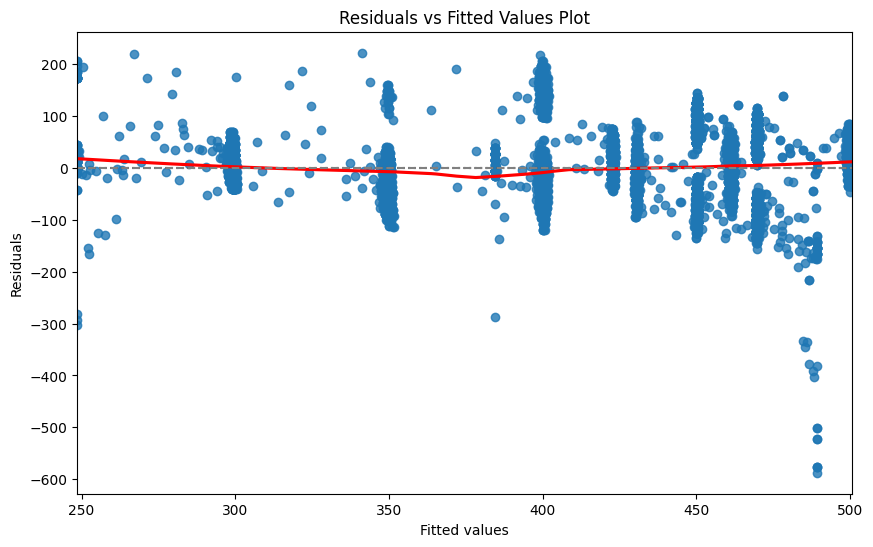

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

# Residual vs Fitted Plot

The residual vs fitted plot will help us determine if the assumption of linearity and homoscedasticity has been violated. At first glace, you might be worried because you can see bands of vertical dots clustering together forming a pattern a leading to a violation of linearity. However, we should remember that we have categorical data in this model. So long as the vertical cluters of points appear evenly distributed around the zero line, as they are here, we should be okay. There is no notable trend or curvature in the distribution of points, so the assumption of linearity should not be violated.

The other thing to note about this plot is that, aside from a few outliers, there is no notable trumpetting or non-uniformity in the variance. Therefore, the assumption of homoscedasticity holds.

#